# This code finds the normalized (z-scored) log amplitude of a recording, then sets a threshold to detect if  there is song in the recording

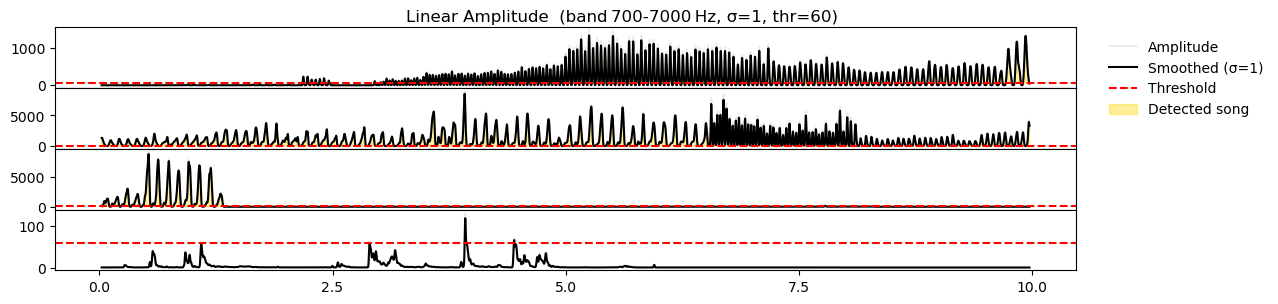

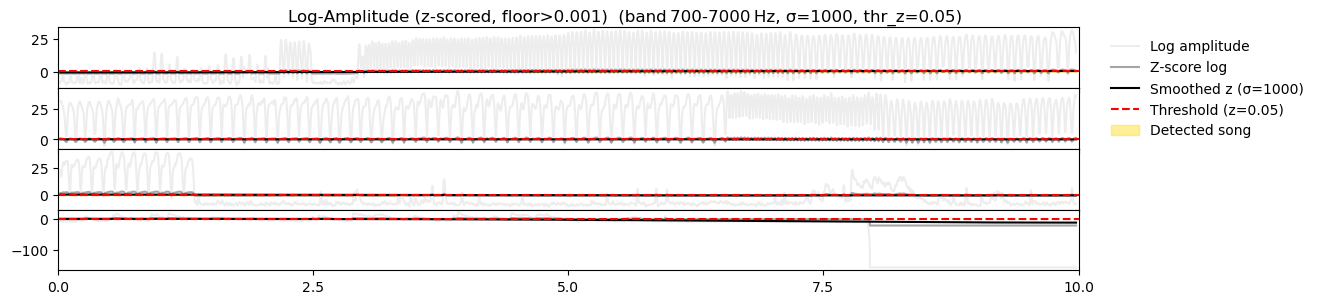

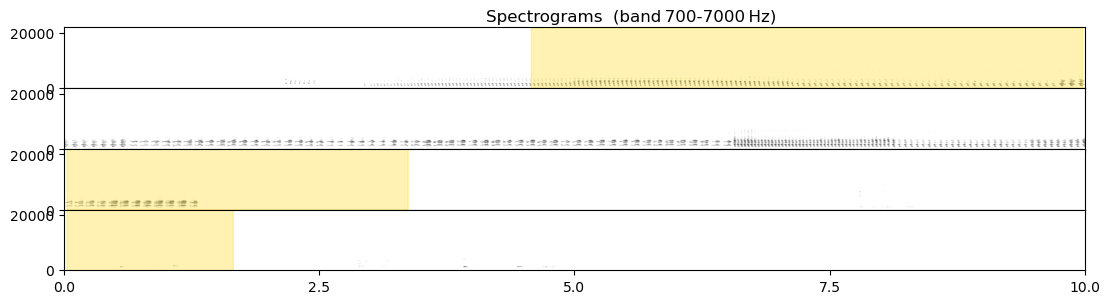


Detected song intervals (s):
      4.57 –     9.97
     20.02 –    23.37
     30.02 –    31.66


In [4]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk
from pathlib import Path
from typing import Optional, List, Tuple

# ------------------------------------------------------------
def get_screen_resolution() -> Tuple[float, float]:
    root = tk.Tk(); root.withdraw()
    w_px, h_px = root.winfo_screenwidth(), root.winfo_screenheight()
    root.destroy()
    return w_px / 100, h_px / 100            # ≈‑inch assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
eps = np.finfo(float).eps                   # tiny constant to avoid log(0)

# ------------------------------------------------------------
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray,
                      t_offset: float) -> List[Tuple[float, float]]:
    """Translate a boolean mask → list of absolute start/stop pairs (s)."""
    intervals: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, v in enumerate(mask):
        if v and not in_run:                 # start new run
            in_run, start = True, times[idx] + t_offset
        elif not v and in_run:               # finish run
            intervals.append((start, times[idx] + t_offset))
            in_run = False
    if in_run:                               # run continues to segment end
        intervals.append((start, times[-1] + t_offset))
    return intervals

# ------------------------------------------------------------
# ------------------------------------------------------------
def plot_spectrograms_by_segment(
        file_path: str,
        segment_duration: float = 10,
        bandpass_filter_low_cut: float = 500,
        bandpass_filter_high_cut: float = 8000,
        sigma: float = 100,
        threshold: float = 0.05,
        sigma_z: Optional[float] = None,
        threshold_z: Optional[float] = None,
        log_base: float = 10,
        zscore_floor: float = 1e-3          # <-- NEW: ignore weaker frames
    ) -> List[Tuple[float, float]]:
    """
    Visualise a WAV file in three aligned tracks (linear amp, z‑scored log amp,
    spectrogram) and return detected song intervals.

    Frames whose *linear* amplitude ≤ `zscore_floor` are excluded when computing
    the z‑score statistics so the added epsilon does not skew μ / σ.
    """

    if sigma_z is None:
        sigma_z = sigma

    # ---------- Load & band‑pass filter ----------
    sr, data = wavfile.read(file_path)
    if data.ndim > 1:                        # stereo → mono
        data = data.mean(axis=1)
    wp = [bandpass_filter_low_cut / (sr / 2),
          bandpass_filter_high_cut / (sr / 2)]
    b, a = ellip(5, 0.2, 40, wp, btype='band')
    data = filtfilt(b, a, data)

    # ---------- Segment bookkeeping ----------
    seg_len = int(segment_duration * sr)
    n_seg   = int(np.ceil(len(data) / seg_len))

    # ---------- Figure stacks ----------
    fig1, axs_lin = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={'hspace': 0})
    fig2, axs_log = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={'hspace': 0})
    fig3, axs_spc = plt.subplots(n_seg, 1, figsize=(width_inches, 3),
                                 sharex=True, gridspec_kw={'hspace': 0})
    if n_seg == 1:
        axs_lin, axs_log, axs_spc = [axs_lin], [axs_log], [axs_spc]

    detected: List[Tuple[float, float]] = []

    # ---------- Per‑segment processing ----------
    for i in range(n_seg):
        # --- slice / zero‑pad the segment ---
        seg = np.zeros(seg_len)
        start = i * seg_len
        seg[:max(0, min(seg_len, len(data) - start))] = data[start:start + seg_len]

        # --- spectrogram ---
        f, t, Sxx = spectrogram(seg, fs=sr,
                                window=windows.gaussian(2048, 2048 / 8),
                                nperseg=2048, noverlap=2048 - 119)
        Sxx_db = 10 * np.log10(Sxx + eps)
        Sxx_db = np.clip(Sxx_db, -2, None)                # floor at ‑2 dB
        Sxx_n  = (Sxx_db - Sxx_db.min()) / (Sxx_db.max() - Sxx_db.min())

        # --- band‑limited energy ---
        rows = (f >= bandpass_filter_low_cut) & (f <= bandpass_filter_high_cut)
        amp = np.sum(Sxx[rows, :], axis=0)                # linear power

        # ------------ LINEAR track ------------
        amp_s = gaussian_filter1d(amp, sigma=sigma)
        mask_lin = amp_s > threshold

        axL = axs_lin[i]
        axL.plot(t, amp,    color='lightgray', alpha=0.4,
                 label='Amplitude' if i == 0 else None)
        axL.plot(t, amp_s,  color='black',
                 label=f'Smoothed (σ={sigma})' if i == 0 else None)
        axL.axhline(threshold, color='red', ls='--',
                    label='Threshold' if i == 0 else None)
        axL.fill_between(t, amp_s, threshold, where=mask_lin,
                         color='gold', alpha=0.4,
                         label='Detected song' if i == 0 else None)
        axL.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axL.legend(fontsize=10, loc='upper left',
                       bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ------------ LOG (z‑scored) track ------------
        amp_log = (10 * np.log10(amp + eps) if log_base == 10
                   else np.log(amp + eps))

        # --- NEW: compute μ, σ only from frames with amp > zscore_floor -----
        valid = amp > zscore_floor
        if np.any(valid):
            mu  = amp_log[valid].mean()
            sd  = amp_log[valid].std(ddof=0) + eps
        else:                                 # fallback: use entire vector
            mu  = amp_log.mean()
            sd  = amp_log.std(ddof=0) + eps

        amp_log_z   = (amp_log - mu) / sd
        amp_log_z_s = gaussian_filter1d(amp_log_z, sigma=sigma_z)

        if threshold_z is None and i == 0:
            threshold_z = np.percentile(amp_log_z_s, 90)

        mask_log = amp_log_z_s > threshold_z
        detected.extend(mask_to_intervals(mask_log, t, i * segment_duration))

        axLg = axs_log[i]
        axLg.plot(t, amp_log,     color='lightgray', alpha=0.4,
                  label='Log amplitude' if i == 0 else None)
        axLg.plot(t, amp_log_z,   color='dimgray',  alpha=0.6,
                  label='Z‑score log' if i == 0 else None)
        axLg.plot(t, amp_log_z_s, color='black',
                  label=f'Smoothed z (σ={sigma_z})' if i == 0 else None)
        axLg.axhline(threshold_z, color='red', ls='--',
                     label=f'Threshold (z={threshold_z:.2f})' if i == 0 else None)
        axLg.fill_between(t, amp_log_z_s, threshold_z, where=mask_log,
                          color='gold', alpha=0.4,
                          label='Detected song' if i == 0 else None)
        axLg.set_xlim(0, segment_duration)
        axLg.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))
        if i == 0:
            axLg.legend(fontsize=10, loc='upper left',
                        bbox_to_anchor=(1.02, 1.0), frameon=False)

        # ------------ SPECTROGRAM track ------------
        axS = axs_spc[i]
        axS.imshow(Sxx_n, aspect='auto', origin='lower',
                   extent=[0, segment_duration, f.min(), f.max()],
                   cmap='binary')
        axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
        axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude (z‑scored, floor>{zscore_floor:g})  '
                  f'(band {bp}, σ={sigma_z}, thr_z={threshold_z:.2f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.8)

    plt.show()

    # ---------- Console output ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected


        # ------------ SPECTROGRAM track ------------
    axS = axs_spc[i]
    axS.imshow(Sxx_n, aspect='auto', origin='lower',
                extent=[0, segment_duration, f.min(), f.max()],
                cmap='binary')
    axS.fill_between(t, f.min(), f.max(), where=mask_log, color='gold', alpha=0.3)
    axS.set_xticks([] if i < n_seg - 1 else np.linspace(0, segment_duration, 5))

    # ---------- Titles & layout ----------
    bp = f"{bandpass_filter_low_cut}-{bandpass_filter_high_cut} Hz"
    fig1.suptitle(f'Linear Amplitude  (band {bp}, σ={sigma}, thr={threshold})', fontsize=12)
    fig2.suptitle(f'Log‑Amplitude (z‑scored)  (band {bp}, σ={sigma_z}, thr_z={threshold_z:.2f})',
                  fontsize=12)
    fig3.suptitle(f'Spectrograms  (band {bp})', fontsize=12)
    for fig in (fig1, fig2, fig3):
        fig.subplots_adjust(hspace=0, top=0.92, right=0.8)   # space for legends

    plt.show()

    # ---------- Console output ----------
    print("\nDetected song intervals (s):")
    for s, e in detected:
        print(f"  {s:8.2f} – {e:8.2f}")
    return detected

# ------------------------------------------------------------
if __name__ == "__main__":
    wav_path = Path(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/"
        "data_inputs/USA5510_unsegmented_songs/55/"
        "USA5510_45755.25619988_4_8_7_6_59.wav"
    )
    if wav_path.exists():
        plot_spectrograms_by_segment(
            file_path=str(wav_path),
            segment_duration=10,
            bandpass_filter_low_cut=700,
            bandpass_filter_high_cut=7000,
            sigma=1 ,             # for linear trace
            threshold=60,
            sigma_z=1000,          # for z‑scored log trace
            threshold_z=0.05      # z units; set None to auto‑estimate
        )
    else:
        print("Example WAV not found:", wav_path)
